# Online Learning and Prediction of Time-series with OR-ELM

Online-Recurrent-Extreme-Learning-Machine (OR-ELM) for time-series prediction, implemented in python.

[sorce code](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine.git)


## Requirements
* Python 2.7
* Numpy
* Matplotlib
* pandas
* Expsuite (included in this repository)

## Dataset
* NYC taxi passenger count
 * Prediction of the New York City taxi passenger data. left.
Example portion of taxi passenger data (aggregated at 30 min
intervals).
  * public data stream provided by the [New
York City Transportation Authority](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml )
  * preprocessed (aggregated at 30 min intervals) by Cui, Yuwei, et al. in ["A comparative study of HTM and other neural network models for online sequence learning with streaming data." Neural Networks (IJCNN), 2016 International Joint Conference on. IEEE, 2016.](http://ieeexplore.ieee.org/abstract/document/7727380/)
  , [code](https://github.com/numenta/htmresearch/tree/master/projects/sequence_prediction)

![example](https://raw.githubusercontent.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine/master/fig/NYCexample.png)



## Setup


### Clone OR-ELM Github repository

In [0]:
!git clone https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine.git

Cloning into 'Online-Recurrent-Extreme-Learning-Machine'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1091 (delta 0), reused 0 (delta 0), pack-reused 1088
Receiving objects: 100% (1091/1091), 188.20 MiB | 22.27 MiB/s, done.
Resolving deltas: 100% (315/315), done.


In [0]:
import os
print(os.getcwd())
!ls
os.chdir('Online-Recurrent-Extreme-Learning-Machine')
!ls

/content/Online-Recurrent-Extreme-Learning-Machine
algorithms				   plotResults.py
data					   prediction
errorMetrics.py				   README.md
expsuite				   result
fig					   run.py
Online-Recurrent-Extreme-Learning-Machine  timeseries_prediction.ipynb
plot.py
algorithms	 expsuite  plotResults.py  result
data		 fig	   prediction	   run.py
errorMetrics.py  plot.py   README.md	   timeseries_prediction.ipynb


### Import libraries

In [0]:
import csv
#from optparse import OptionParser
from matplotlib import pyplot as plt
import numpy as np
from scipy import random
import pandas as pd
from numpy.linalg import pinv
from numpy.linalg import inv
random.seed(0)

### Set hyper-parameters for the dataset

In [0]:
numLags = 100
predictionStep = 5




### Read dataset

In [0]:
dataSet = 'nyc_taxi'
filePath = 'data/'+dataSet+'.csv'
df = pd.read_csv(filePath, header=0, skiprows=[1,2], names=['time', 'data', 'timeofday', 'dayofweek'])
df.head(5)

,time,data,timeofday,dayofweek
0,2014-07-01 00:00:00,10844,0,1
1,2014-07-01 00:30:00,8127,30,1
2,2014-07-01 01:00:00,6210,60,1
3,2014-07-01 01:30:00,4656,90,1
4,2014-07-01 02:00:00,3820,120,1


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
time         17520 non-null object
data         17520 non-null int64
timeofday    17520 non-null int64
dayofweek    17520 non-null int64
dtypes: int64(3), object(1)
memory usage: 547.6+ KB


In [0]:
df.isnull().sum()

time         0
data         0
timeofday    0
dayofweek    0
dtype: int64

In [0]:
  # standardize data by subtracting mean and dividing by std
  meanSeq = np.mean(df['data'])
  stdSeq = np.std(df['data'])
  df['data'] = (df['data'] - meanSeq)/stdSeq

In [0]:
df.head()

,time,data,timeofday,dayofweek
0,2014-07-01 00:00:00,-0.620382,0,1
1,2014-07-01 00:30:00,-1.018706,30,1
2,2014-07-01 01:00:00,-1.299746,60,1
3,2014-07-01 01:30:00,-1.527569,90,1
4,2014-07-01 02:00:00,-1.650131,120,1


### Prepare input-target pairs 

In [0]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), 1))
  for i in xrange(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['data'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['data'][i+predictionStep]
  print('input shape: ',X.shape)
  print('target shape: ',T.shape)
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags, predictionStep)

generate time embedded matrix
('input shape: ', (17520, 100))
('target shape: ', (17520, 1))


In [0]:
print(X.shape, T.shape)

((17520, 100), (17520, 1))


# Online Sequential Extreme Learning Machine (OS-ELM)

## Base operation: linear layer with nonlinear activation using NumPy

In [0]:
weights = np.random.random((20,100))
print('weights:',weights.shape)

bias = np.random.random((1,20)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,100))
print('input features:', features.shape)

def linear(features,weights,bias):
   return np.dot(features, np.transpose(weights)) + bias

hidden = linear(features,weights,bias)
print('hidden (before nonlinear activation):', hidden.shape)

def sigmoidActFunc(features):
  return 1.0 / (1.0 + np.exp(-features))

hidden = sigmoidActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)

def reluActFunc(features):
  return np.maximum(0,features)
hidden = reluActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)


('weights:', (20, 100))
('bias:', (1, 20))
('input features:', (1, 100))
('hidden (before nonlinear activation):', (1, 20))
('hidden (after nonlinear activateion):', (1, 20))
('hidden (after nonlinear activateion):', (1, 20))


##Set model hyper-parameters

In [0]:
nDimInput = 100
nDimOutput = 1
numNeurons = 25
lamb=0.0001
outputWeightFF = 0.92 

## OSELM implementation

In [0]:
class OSELM(object):
  def __init__(self, inputs, outputs, numHiddenNeurons, forgettingFactor=0.999):
    self.name = 'OSELM'
    self.inputs = inputs
    self.outputs = outputs
    self.numHiddenNeurons = numHiddenNeurons

    # input to hidden weights
    self.inputWeights = None
    # bias of hidden units
    self.bias = None
    # hidden to output layer connection
    self.beta = None
    # auxiliary matrix used for sequential learning
    self.M = None

    self.forgettingFactor = forgettingFactor

  def calculateHiddenLayerActivation(self, features):
    """
    Calculate activation level of the hidden layer
    :param features feature matrix with dimension (numSamples, numInputs)
    :return: activation level (numSamples, numHiddenNeurons)
    """
    V = linear(features, self.inputWeights,self.bias)
    #H = sigmoidActFunc(V)
    H = reluActFunc(V)
    return H


  def initializePhase(self, lamb=0.0001):
    """
    Step 1: Initialization phase
    """
    # randomly initialize the input->hidden connections
    self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
    self.inputWeights = self.inputWeights * 2 - 1
    self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1
    # auxiliary matrix used for sequential learning
    self.M = inv(lamb*np.eye(self.numHiddenNeurons))
    # hidden to output layer connection
    self.beta = np.zeros([self.numHiddenNeurons,self.outputs])



  def train(self, features, targets):
    """
    Step 2: Sequential learning phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    (numSamples, numOutputs) = targets.shape
    assert features.shape[0] == targets.shape[0]

    H = self.calculateHiddenLayerActivation(features)
    Ht = np.transpose(H)


    self.M = (1/self.forgettingFactor) * self.M - np.dot((1/self.forgettingFactor) * self.M,
                                     np.dot(Ht, np.dot(
                                       pinv(np.eye(numSamples) + np.dot(H, np.dot((1/self.forgettingFactor) * self.M, Ht))),
                                       np.dot(H, (1/self.forgettingFactor) * self.M))))
    self.beta = self.beta + np.dot(self.M, np.dot(Ht, targets - np.dot(H, self.beta)))

  def predict(self, features):
    """
    Make prediction with feature matrix
    :param features: feature matrix with dimension (numSamples, numInputs)
    :return: predictions with dimension (numSamples, numOutputs)
    """
    H = self.calculateHiddenLayerActivation(features)
    prediction = np.dot(H, self.beta)
    return prediction



In [0]:
net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

### Online learning and prediction of OS-ELM

In [0]:
  predictions= []
  target= []

  for i in xrange(numLags, len(df)-predictionStep-1):
    net.train(X[[i], :], T[[i], :])
    Y = net.predict(X[[i+1], :])

    predictions.append(Y[0][0])
    target.append(T[i][0])

    print "{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} ".format(i, target[-1], predictions[-1])

  ### Evaluation: Calculate total Normalized Root Mean Square Error (NRMSE)

In [0]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))


NRMSE 0.322358641476


### Plot predictions and target values

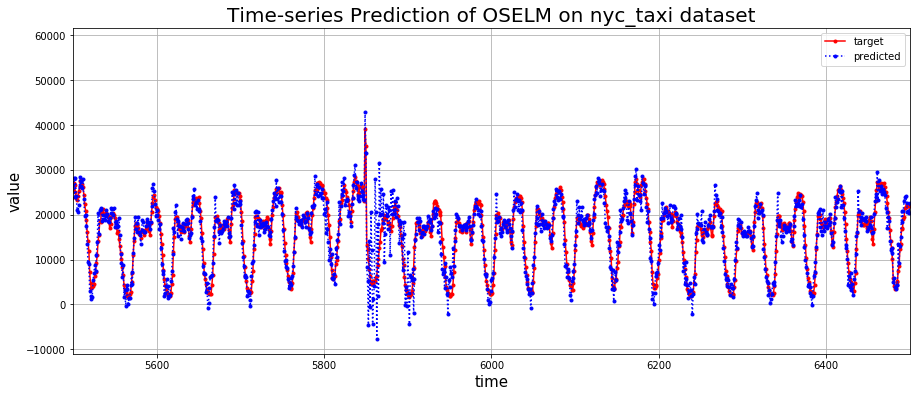

Prediction plot is saved to./predictionPlot.png


In [0]:
  algorithm= net.name
  plt.figure(figsize=(15,6))
  targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
  predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
  plt.xlim([5500,6500])
  #plt.ylim([0, 30000])
  plt.ylabel('value',fontsize=15)
  plt.xlabel('time',fontsize=15)
  plt.ion()
  plt.grid()
  plt.legend(handles=[targetPlot, predictedPlot])
  plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
  plot_path = './predictionPlot.png'
  plt.savefig(plot_path,plot_pathbbox_inches='tight')
  plt.draw()
  plt.show()
  plt.pause(0)
  print('Prediction plot is saved to'+plot_path)

## Plot prediction errors

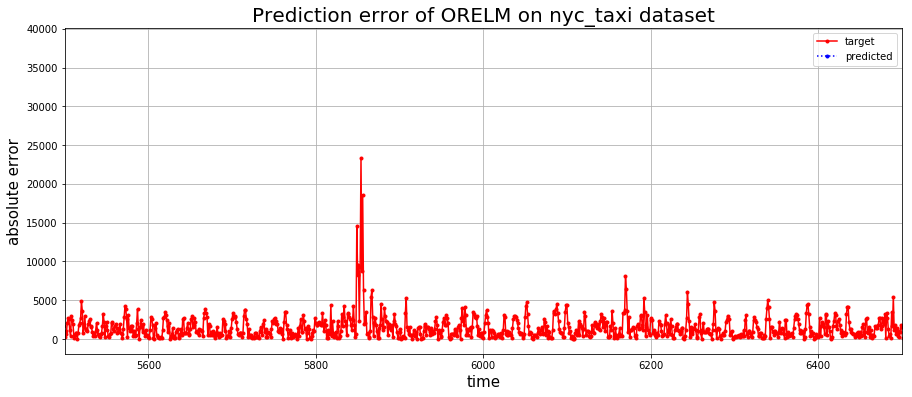

Prediction error plot is saved to./predictionErrorPlot.png


In [53]:
  algorithm= net.name
  plt.figure(figsize=(15,6))
  targetPlot,=plt.plot(np.abs(target-predictions),label='target',color='red',marker='.',linestyle='-')
  plt.xlim([5500,6500])
  #plt.ylim([0, 30000])
  plt.ylabel('absolute error',fontsize=15)
  plt.xlabel('time',fontsize=15)
  plt.ion()
  plt.grid()
  plt.legend(handles=[targetPlot, predictedPlot])
  plt.title('Prediction error of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
  plot_path = './predictionErrorPlot.png'
  plt.savefig(plot_path,plot_pathbbox_inches='tight')
  plt.draw()
  plt.show()
  plt.pause(0)
  print('Prediction error plot is saved to'+plot_path)

# Online Recurrent Extreme Learning Machine (OR-ELM)

## Base operation: recurrent layer with nonlinear activation using NumPy

In [42]:
def linear_recurrent(features, inputW,hiddenW,hiddenA, bias):
  V = np.dot(features, np.transpose(inputW)) + np.dot(hiddenA,hiddenW) + bias
  return V

def layerNormalization(H, scaleFactor=1, biasFactor=0):

  H_normalized = (H-H.mean())/(np.sqrt(H.var() + 0.000001))
  H_normalized = scaleFactor*H_normalized+biasFactor

  return H_normalized

inputW = np.random.random((20,100))
print('input_weights:',inputW.shape)

hiddenW = np.random.random((20,20))
print('hidden_weights:',hiddenW.shape)

bias = np.random.random((1,20)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,100))
print('input features:', features.shape)

hiddenA = np.random.random((1,20))

hidden = linear_recurrent(features,inputW,hiddenW,hiddenA,bias)
print('hidden:',hidden.shape)

hidden = layerNormalization(hidden)
print('hidden:',hidden.shape)


('input_weights:', (20, 100))
('hidden_weights:', (20, 20))
('bias:', (1, 20))
('input features:', (1, 100))
('hidden:', (1, 20))
('hidden:', (1, 20))


## Model hyper-parameters

In [0]:
nDimInput = 100
nDimOutput = 1
numNeurons = 25
lamb=0.0001
LN=True
InWeightFF=1.0
OutWeightFF=0.92
HiddenWeightFF=1.0
AE=True

## ORELM implementation

In [0]:
class ORELM(object):
  def __init__(self, inputs, outputs, numHiddenNeurons, LN=True, AE=True,
               inputWeightForgettingFactor=1.0,
               outputWeightForgettingFactor=1.0,
               hiddenWeightForgettingFactor=1.0):
    self.name = 'ORELM'
    self.inputs = inputs
    self.outputs = outputs
    self.numHiddenNeurons = numHiddenNeurons

    # input to hidden weights
    self.inputWeights  = None
    # hidden layer to hidden layer wieghts
    self.hiddenWeights = None
    # initial hidden layer activation
    self.initial_H = None
    self.H = self.initial_H
    self.LN = LN
    self.AE = AE
    # bias of hidden units
    self.bias = None
    # hidden to output layer connection
    self.beta = None

    # auxiliary matrix used for sequential learning
    self.M = None
    
    self.forgettingFactor = outputWeightForgettingFactor


    if self.AE:
      self.inputAE = OSELM(inputs = inputs,
                            outputs = inputs,
                            numHiddenNeurons = numHiddenNeurons,
                            forgettingFactor=inputWeightForgettingFactor,
                            )

      self.hiddenAE = OSELM(inputs = numHiddenNeurons,
                             outputs = numHiddenNeurons,
                             numHiddenNeurons = numHiddenNeurons,
                             forgettingFactor=hiddenWeightForgettingFactor,
                             )


  def __calculateInputWeightsUsingAE(self, features):
    self.inputAE.train(features,features)
    return self.inputAE.beta

  def __calculateHiddenWeightsUsingAE(self, features):
    self.hiddenAE.train(features,features)
    return self.hiddenAE.beta

  def calculateHiddenLayerActivation(self, features):
    """
    Calculate activation level of the hidden layer
    :param features feature matrix with dimension (numSamples, numInputs)
    :return: activation level (numSamples, numHiddenNeurons)
    """


    if self.AE:
      self.inputWeights = self.__calculateInputWeightsUsingAE(features)

      self.hiddenWeights = self.__calculateHiddenWeightsUsingAE(self.H)

    V = linear_recurrent(features=features,
                         inputW=self.inputWeights,
                         hiddenW=self.hiddenWeights,
                         hiddenA=self.H,
                         bias= self.bias)
    if self.LN:
      V = layerNormalization(V)
    self.H = sigmoidActFunc(V)
    #self.H = reluActFunc(V)

    return self.H


  def initializePhase(self, lamb=0.0001):
    """
    Step 1: Initialization phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    self.initial_H = np.random.random((1, self.numHiddenNeurons)) * 2 -1
    self.H = self.initial_H

    self.M = inv(lamb*np.eye(self.numHiddenNeurons))
    self.beta = np.zeros([self.numHiddenNeurons,self.outputs])

    # randomly initialize the input->hidden connections
    self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
    self.inputWeights = self.inputWeights * 2 - 1
    self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1
    
    if self.AE:
      self.inputAE.initializePhase(lamb=0.00001)
      self.hiddenAE.initializePhase(lamb=0.00001)
    else:
      # randomly initialize the input->hidden connections
      self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
      self.inputWeights = self.inputWeights * 2 - 1

      # hidden layer to hidden layer wieghts
      self.hiddenWeights = np.random.random((self.numHiddenNeurons, self.numHiddenNeurons))
      self.hiddenWeights = self.hiddenWeights * 2 - 1


  def reset(self):
    self.H = self.initial_H

  def train(self, features, targets):
    """
    Step 2: Sequential learning phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    (numSamples, numOutputs) = targets.shape
    assert features.shape[0] == targets.shape[0]

    H = self.calculateHiddenLayerActivation(features)
    Ht = np.transpose(H)
    try:
      scale = 1/(self.forgettingFactor)
      self.M = scale*self.M - np.dot(scale*self.M,
                       np.dot(Ht, np.dot(
          pinv(np.eye(numSamples) + np.dot(H, np.dot(scale*self.M, Ht))),
          np.dot(H, scale*self.M))))

      self.beta = self.beta + np.dot(self.M, np.dot(Ht, targets - np.dot(H, self.beta)))


    except np.linalg.linalg.LinAlgError:
      print "SVD not converge, ignore the current training cycle"
    # else:
    #   raise RuntimeError

  def predict(self, features):
    """
    Make prediction with feature matrix
    :param features: feature matrix with dimension (numSamples, numInputs)
    :return: predictions with dimension (numSamples, numOutputs)
    """
    H = self.calculateHiddenLayerActivation(features)
    prediction = np.dot(H, self.beta)
    return prediction

In [0]:
net = ORELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons, outputWeightForgettingFactor=0.92)
net.initializePhase(lamb=0.0001)

### Online learning and prediction of OR-ELM

In [0]:
  predictions= []
  target= []

  for i in xrange(numLags, len(df)-predictionStep-1):
    net.train(X[[i], :], T[[i], :])
    Y = net.predict(X[[i+1], :])

    predictions.append(Y[0][0])
    target.append(T[i][0])

    print "{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} ".format(i, target[-1], predictions[-1])


### Evaluation: Calculate total Normalized Root Mean Square Error (NRMSE)

In [47]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 0.259309521862


### Plot predictions and target values

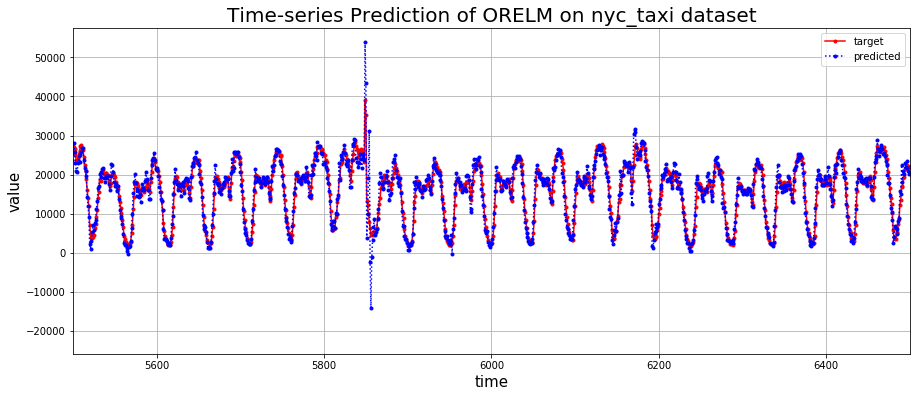

Prediction plot is saved to./predictionPlot.png


In [51]:
  algorithm= net.name
  plt.figure(figsize=(15,6))
  targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
  predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
  plt.xlim([5500,6500])
  #plt.ylim([0, 30000])
  plt.ylabel('value',fontsize=15)
  plt.xlabel('time',fontsize=15)
  plt.ion()
  plt.grid()
  plt.legend(handles=[targetPlot, predictedPlot])
  plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
  plot_path = './predictionPlot.png'
  plt.savefig(plot_path,plot_pathbbox_inches='tight')
  plt.draw()
  plt.show()
  plt.pause(0)
  print('Prediction plot is saved to'+plot_path)

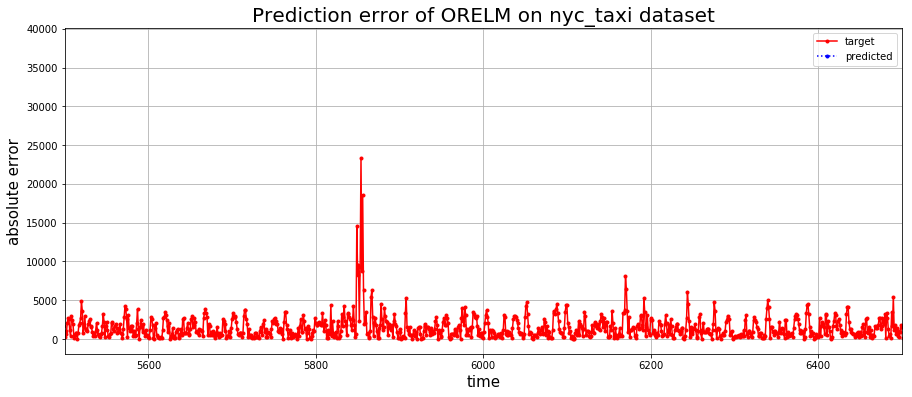

Prediction error plot is saved to./predictionErrorPlot.png


In [52]:
  algorithm= net.name
  plt.figure(figsize=(15,6))
  targetPlot,=plt.plot(np.abs(target-predictions),label='target',color='red',marker='.',linestyle='-')
  plt.xlim([5500,6500])
  #plt.ylim([0, 30000])
  plt.ylabel('absolute error',fontsize=15)
  plt.xlabel('time',fontsize=15)
  plt.ion()
  plt.grid()
  plt.legend(handles=[targetPlot, predictedPlot])
  plt.title('Prediction error of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
  plot_path = './predictionErrorPlot.png'
  plt.savefig(plot_path,plot_pathbbox_inches='tight')
  plt.draw()
  plt.show()
  plt.pause(0)
  print('Prediction error plot is saved to'+plot_path)

# Exercise: Try with a different time-series


## Dataset
* **Bike Sharing Demand** from [kaggle](https://www.kaggle.com/c/bike-sharing-demand/overview) 
 * Historical bike usage patterns are aggregated at 1 hour intervals 
 * You are asked to combine the historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.
 * Goal: NRMSE < 0.6 when prediction_step = 1
 
 ![bike_image](https://storage.googleapis.com/kaggle-competitions/kaggle/3948/media/bikes.png)
 

### Download the dataset

In [0]:
!git clone https://github.com/chickenbestlover/sk_hynix_class.git
!ls
df = pd.read_csv('sk_hynix_class/bike-sharing-demand/train.csv')
df.head()

fatal: destination path 'sk_hynix_class' already exists and is not an empty directory.
algorithms	 Online-Recurrent-Extreme-Learning-Machine  README.md
data		 plot.py				    result
errorMetrics.py  plotResults.py				    run.py
expsuite	 prediction				    sk_hynix_class
fig		 predictionPlot.png


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data Fields

**datetime** - hourly date + timestamp

**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** - 

  1: Clear, Few clouds, Partly cloudy, Partly cloudy 

  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 

  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 

  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

## Preprocess

In [0]:
# seperating season as per values. this is bcoz this will enhance features.
season=pd.get_dummies(df['season'],prefix='season')
df=pd.concat([df,season],axis=1)
# same for weather. this is bcoz this will enhance features.
weather=pd.get_dummies(df['weather'],prefix='weather')
df=pd.concat([df,weather],axis=1)
# now can drop weather and season.
df.drop(['season','weather'],inplace=True,axis=1)
# now most importantly split the date and time as the time of day is expected to effect the no of bikes.
df["hour"] = [t.hour for t in pd.DatetimeIndex(df.datetime)]
df["day"] = [t.dayofweek for t in pd.DatetimeIndex(df.datetime)]
df["month"] = [t.month for t in pd.DatetimeIndex(df.datetime)]
df['year'] = [t.year for t in pd.DatetimeIndex(df.datetime)]
df['year'] = df['year'].map({2011:0, 2012:1})
# now can drop datetime column.
df.drop('datetime',axis=1,inplace=True)
df.drop(['casual','registered'],axis=1,inplace=True)

df.head()

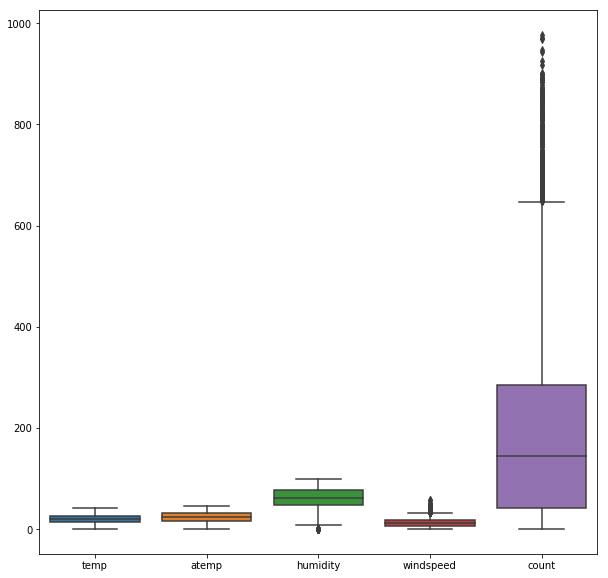

In [0]:
import seaborn as sns
# just to visualize.
sns.boxplot(data=df[['temp',
       'atemp', 'humidity', 'windspeed', 'count']])
fig=plt.gcf()
fig.set_size_inches(10,10)

### Now it's your turn!

Start by normalizing the dataset.

Then make input-target pairs. Targets should be the 'count' column in the dataset.

Declare a predictive network and use it to perform online learning and prediction.

Finally, evaluate the performance of your network and visualize forecast results.

### What's more?
* Use multi-step prediction model

![multistep](https://raw.githubusercontent.com/chickenbestlover/RNN-Time-series-Anomaly-Detection/master/fig/arch.png)

* Design anomaly score

![anomalyscore](https://raw.githubusercontent.com/chickenbestlover/RNN-Time-series-Anomaly-Detection/master/fig/equation1.gif)

* Evaluate anomaly detection performance
    * precision, recall, F1
    
![f1](https://raw.githubusercontent.com/chickenbestlover/RNN-Time-series-Anomaly-Detection/master/fig/fig_f_beta_channel0.png)

* Use reconstruction error based anomaly detection model (next lecture)



## References
* [Malhotra, Pankaj, et al. "Long short term memory networks for anomaly detection in time series." Proceedings. Presses universitaires de Louvain, 2015.](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2015-56.pdf)


* [Malhotra, Pankaj, et al. "LSTM-based encoder-decoder for multi-sensor anomaly detection." arXiv preprint arXiv:1607.00148 (2016).](https://arxiv.org/pdf/1607.00148.pdf)

* [multi-step prediction based anomaly detection tutorial](https://github.com/chickenbestlover/RNN-Time-series-Anomaly-Detection)



